In [1]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(15, 10)})
sns.set(font_scale=2)
sns.set_style("whitegrid")
sns.set_context("talk")
from pmdarima import auto_arima 
import pandas as pd 
import numpy as np
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from plotly.graph_objects import *
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model  import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
df = pd.read_csv('../datatest/monthly-car-sales.csv')

In [3]:
df.head()

,Month,Sales
0,1960-01,6550
1,1960-02,8728
2,1960-03,12026
3,1960-04,14395
4,1960-05,14587


<AxesSubplot:>

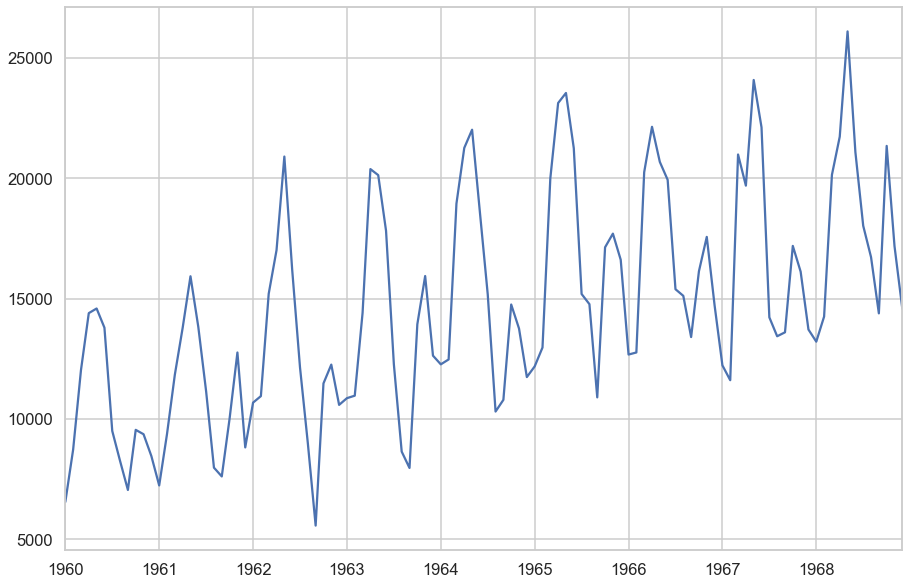

In [4]:
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month',inplace=True)
df.index = pd.DatetimeIndex(df.index.values, freq=df.index.inferred_freq)
df['Sales'].plot()

Задание №1 
-------
Разложить на компоненты, используя функцию <code>seasonal_decompose</code>

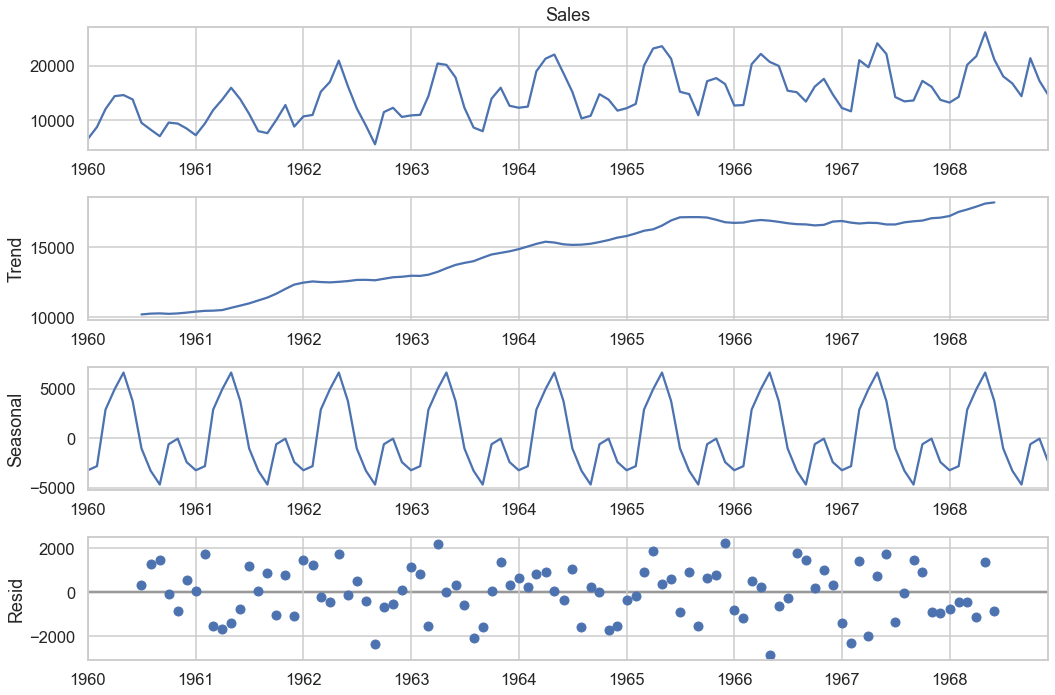

In [5]:
# your code
result=seasonal_decompose(df['Sales'], model='additive', period=12)
result.plot()
plt.show()

Проверим, является ли временной ряд стационарным. 

In [6]:
result = adfuller(df['Sales'])
print('p-value: %f' % result[1])

p-value: 0.663269


Ряд не стационарный, попробуем сделать одну дифференциацию.

In [7]:
df['diff'] = df['Sales'].diff()
df.dropna(inplace=True)

result = adfuller(df['diff'])
print('p-value: %f' % result[1])

p-value: 0.000000


<AxesSubplot:>

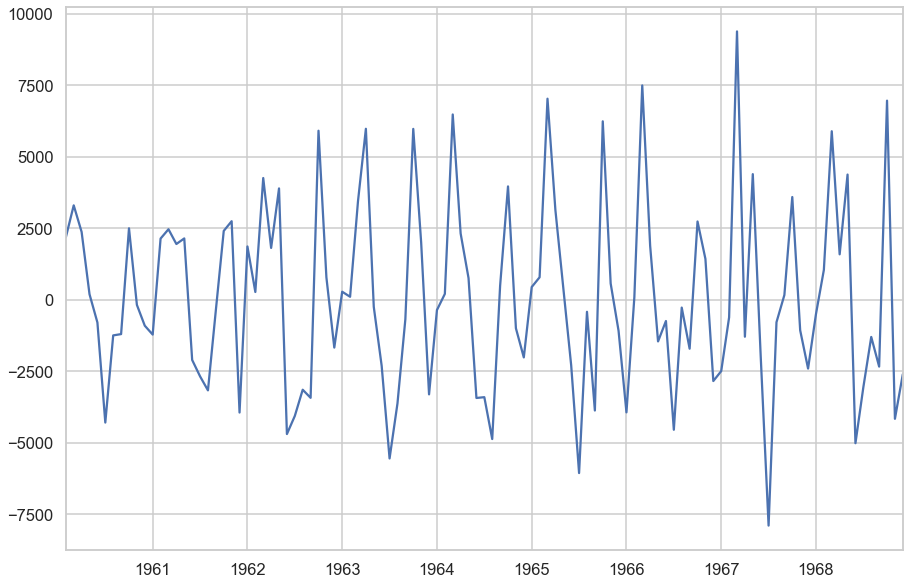

In [8]:
df['diff'].plot()

Задание №2
------
Сделать графики авто корреляции и часточной автокорреляции с помощью функций <code> plot_acf </code> и <code> plot_pacf </code>.

Если при использовании функции <code> plot_pacf </code> появляется ошибка <code>RuntimeWarning: invalid value encountered in sqrt</code> , можно изменить дефолтное значение метода, используемого для рассчета частичной автокорреляции. Почитать про методы можно почитать здесь:
<a>https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_pacf.html</a>

Попробуйте использовать <code> method = 'ldadjusted' </code>

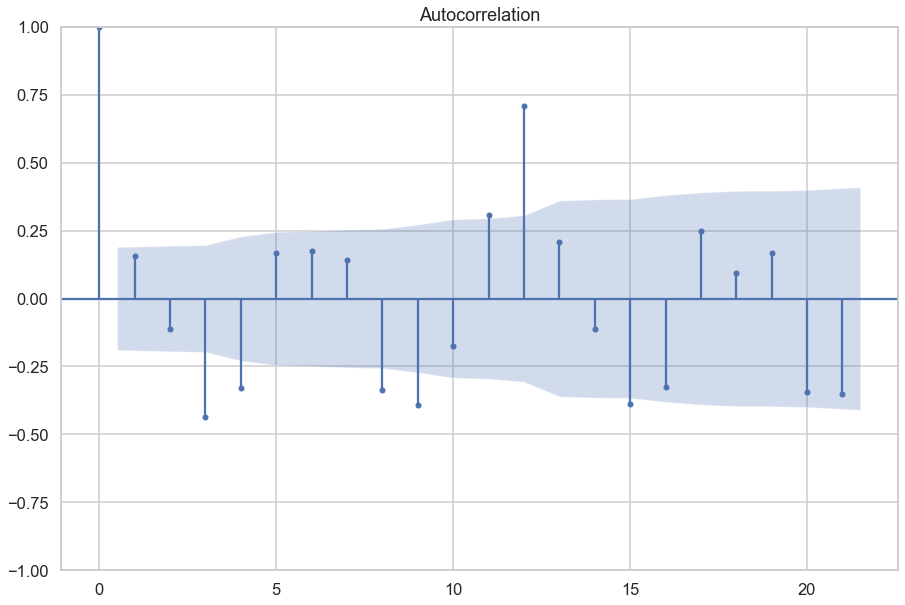

In [10]:
#your code 
plot_acf(df['diff'])
plt.show()

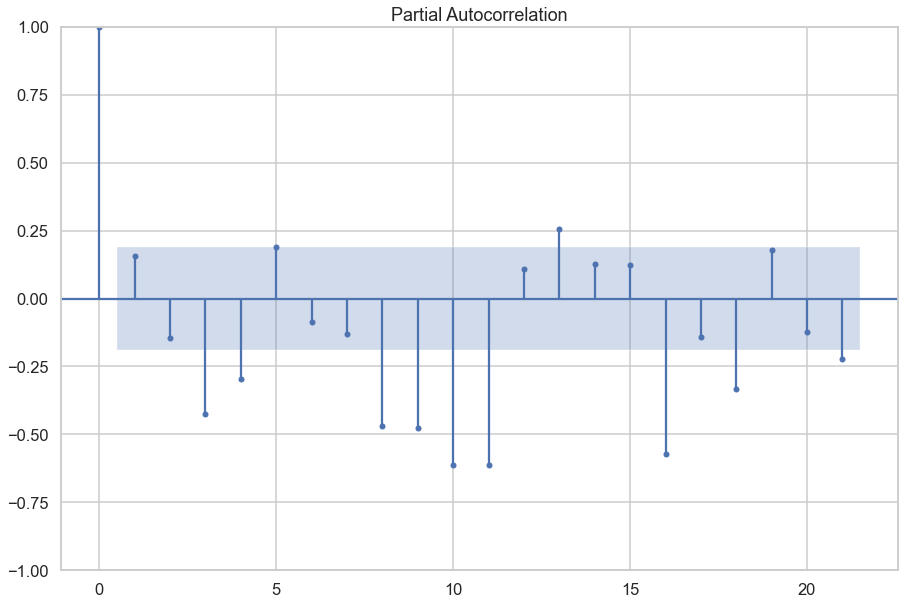

In [11]:
#your code 
plot_pacf(df['diff'], method ='ldadjusted')
plt.show()

In [12]:
# split data into train and test

# what is the size of 80% ? 
size = int(len(df)*0.8)

# use 80% for train and 20% for test

train, test = df[0:size], df[size:]
print(f'Length of train is {len(train)} and lenght of test is {len(test)}')

Length of train is 85 and lenght of test is 22


In [13]:
model = ARIMA(train['Sales'], order=(2,1,2))
model_fit = model.fit(cov_type = 'approx')
preds = model_fit.forecast(len(test))

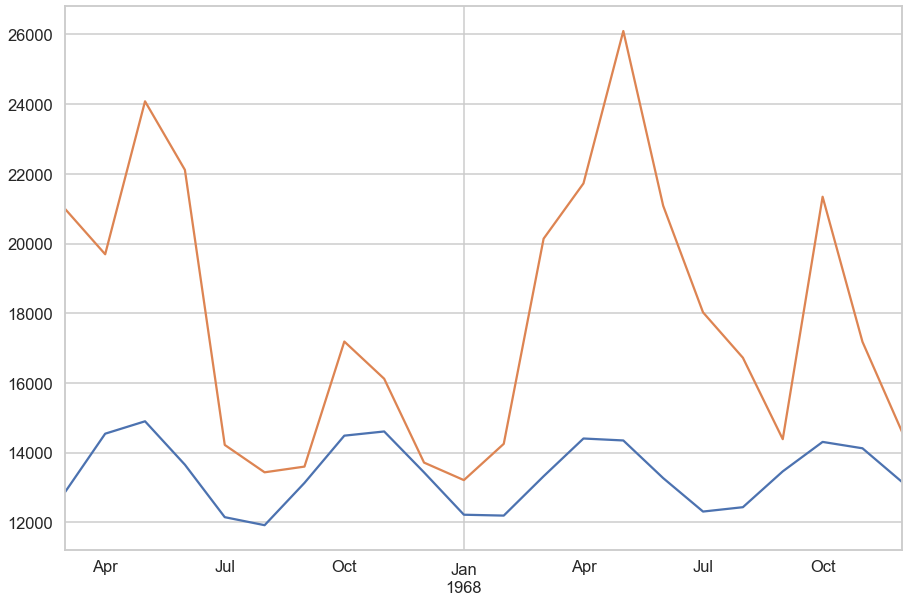

In [14]:
preds.plot()
test['Sales'].plot()
plt.show()

Задание №3
===
Используя <code>auto_arima</code> найти оптимальный набор параметров, натренировать на нем модель (на тренировочных данных) и сделать прогноз для теста. Сделать графики и посчитать качество предсказаний, используя метрики <code> r2_score </code> и <code> mean_absolute_error </code>.

In [15]:
from sklearn.metrics import r2_score, mean_squared_error

In [17]:
# your code
model = auto_arima(train['Sales'],
                   start_p=1,
                   start_q=1,
                   max_p=12,
                   max_q=12,
                   start_P=0,
                   start_Q=0,
                   max_P=12,max_Q=12,
                   m=12,seasonal=True,
                   stepwise=False,
                   suppress_warnings=True,D=1,d=1,error_action='warn',random_state=20,n_fits=50, 
                  n_jobs=-1)

In [18]:
model.summary()  

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   85
Model:             SARIMAX(0, 1, 1)x(4, 1, [], 12)   Log Likelihood                -628.522
Date:                             Tue, 28 Jun 2022   AIC                           1269.044
Time:                                     22:38:37   BIC                           1282.704
Sample:                                          0   HQIC                          1274.483
                                              - 85                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7125      0.099     -7.200      0.000      -0.906      -0.519
ar.S.L12      -0.3246      0.113     -2.873      0.004      -0.546      -0.103
ar.S.L24       0.1052      0.171      0.616      0.538      -0.230       0.440
ar.S.L36      -0.0283      0.126     -0.224      0.823      -0.276       0.219
ar.S.L48      -0.4163      0.125     -3.343      0.001      -0.660      -0.172
sigma2      1.842e+06   3.54e+05      5.210      0.000    1.15e+06    2.53e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 1.39
Prob(Q):                              0.84   Prob(JB):                         0.50
Heteroskedasticity (H):               0.86   Skew:                             0.34
Prob(H) (two-sided):                  0.72   Kurtosis:                         3.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
order = (0,1,1)
seasonal_order = (4,1,0,12)


SARIMA_model = ARIMA(train['Sales'], order=order, seasonal_order=seasonal_order)
SARIMA_model_fit = SARIMA_model.fit()
predictions = SARIMA_model_fit.forecast(len(test))

In [20]:
train_trace = Scatter(x=df.index, y = df['Sales'], name = 'Train')
test_trace = Scatter(x=test.index, y = test['Sales'], name = 'Test')
pred_trace = Scatter(x=test.index, y = predictions, name = 'Forecast SARIMA')

mae = np.round(mean_squared_error(test['Sales'], predictions),2)
r2 = np.round(r2_score(test['Sales'], predictions),2)
title = f'MAE = {mae}, R2 = {r2}'

iplot(Figure(data=[train_trace, test_trace, pred_trace],
            layout=Layout(title=title)))